In [27]:
import matplotlib.pyplot as plt
import missingno
import nltk
from nltk.tokenize import RegexpTokenizer
import numpy as np
import pandas as pd
from pathlib import Path
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

import tensorflow as tf
import os
os.environ.setdefault("TF_CPP_MIN_LOG_LEVEL", "2")  # Report only TF errors by default

'2'

In [30]:
SEED = 42
BATCH_SIZE = 8

tf.keras.utils.set_random_seed(SEED)
tf.config.threading.set_inter_op_parallelism_threads(1)
tf.config.threading.set_intra_op_parallelism_threads(1)

In [2]:
dataset_path = Path("./leetcode_dataset.csv")

if dataset_path.exists():
    df = pd.read_csv("./leetcode_dataset.csv")

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1825 entries, 0 to 1824
Data columns (total 19 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 1825 non-null   int64  
 1   title              1825 non-null   object 
 2   description        1825 non-null   object 
 3   is_premium         1825 non-null   int64  
 4   difficulty         1825 non-null   object 
 5   solution_link      987 non-null    object 
 6   acceptance_rate    1825 non-null   float64
 7   frequency          1825 non-null   float64
 8   url                1825 non-null   object 
 9   discuss_count      1825 non-null   int64  
 10  accepted           1825 non-null   object 
 11  submissions        1825 non-null   object 
 12  companies          1749 non-null   object 
 13  related_topics     1571 non-null   object 
 14  likes              1825 non-null   int64  
 15  dislikes           1825 non-null   int64  
 16  rating             1825 

In [4]:
df = df.drop(columns=["is_premium", "solution_link", "url", "companies", "asked_by_faang", "frequency"])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1825 entries, 0 to 1824
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 1825 non-null   int64  
 1   title              1825 non-null   object 
 2   description        1825 non-null   object 
 3   difficulty         1825 non-null   object 
 4   acceptance_rate    1825 non-null   float64
 5   discuss_count      1825 non-null   int64  
 6   accepted           1825 non-null   object 
 7   submissions        1825 non-null   object 
 8   related_topics     1571 non-null   object 
 9   likes              1825 non-null   int64  
 10  dislikes           1825 non-null   int64  
 11  rating             1825 non-null   int64  
 12  similar_questions  745 non-null    object 
dtypes: float64(1), int64(5), object(7)
memory usage: 185.5+ KB


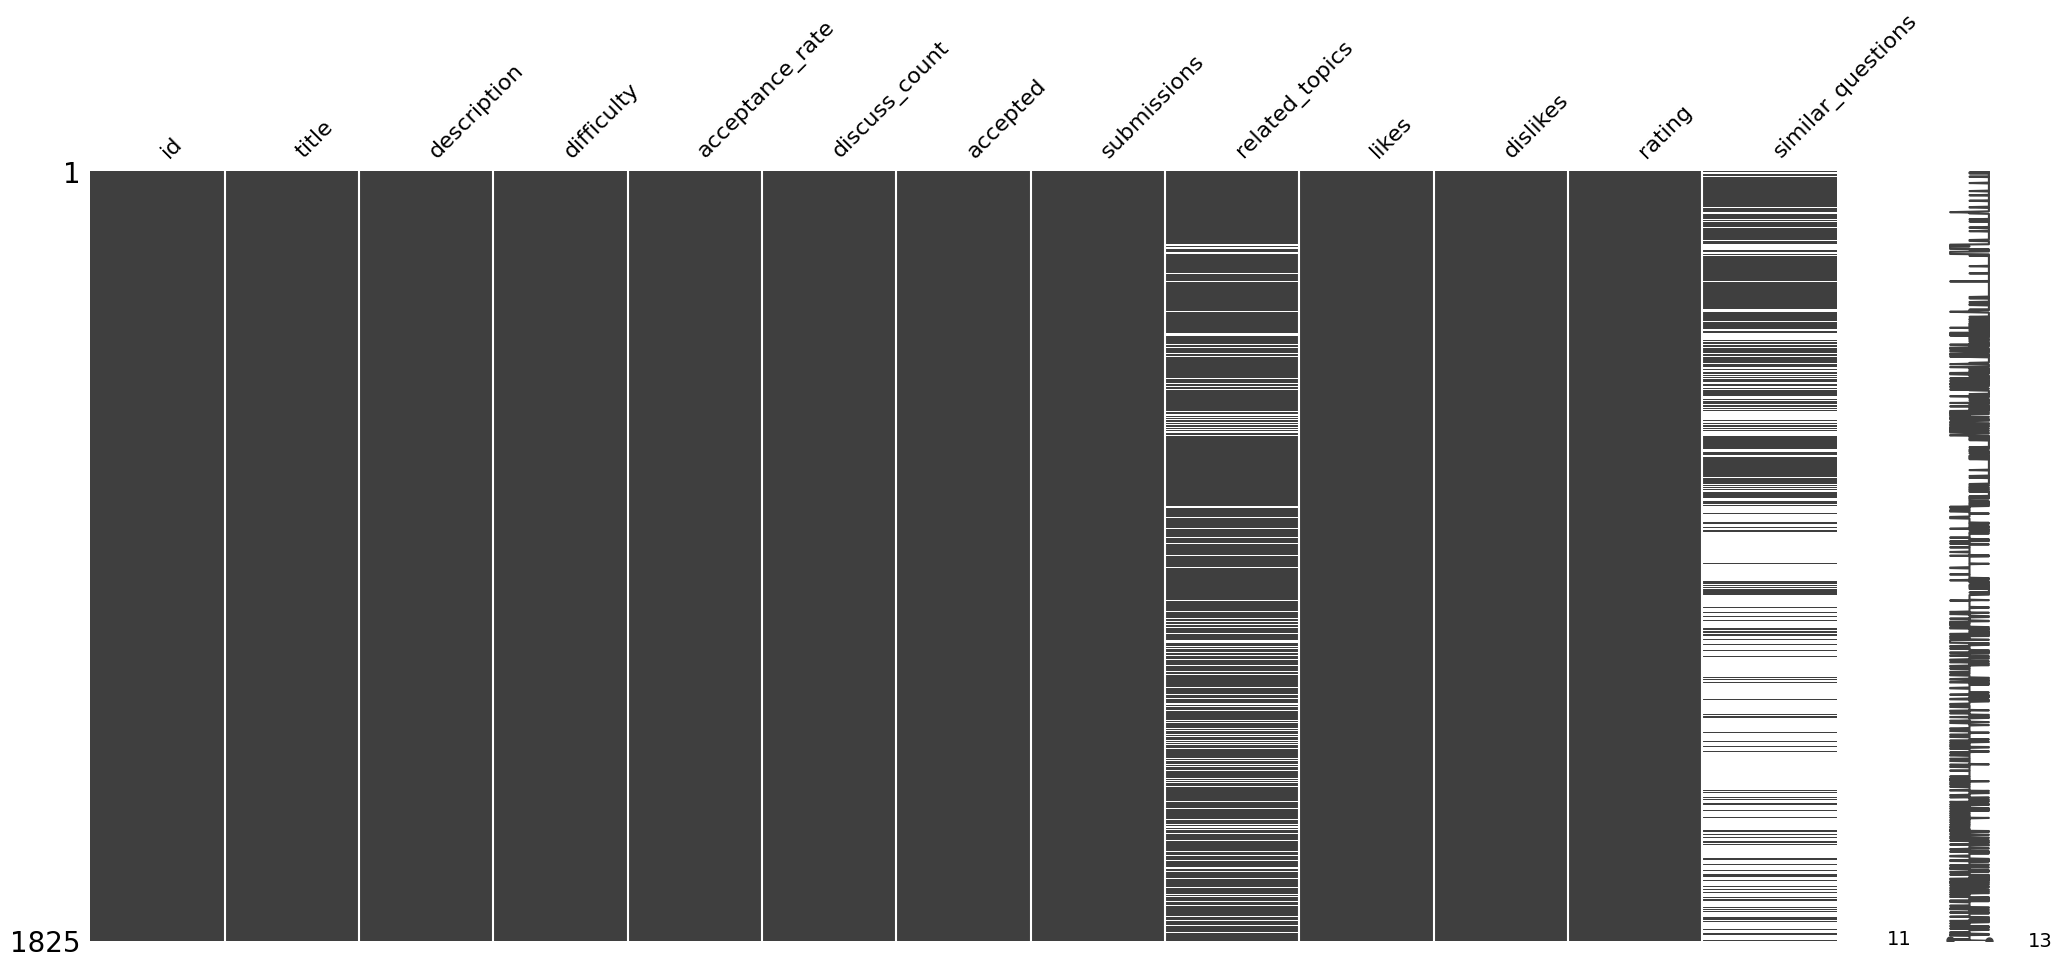

In [5]:
missingno.matrix(df)
plt.show()

In [6]:
df_numerical, df_categorical = df.select_dtypes([np.number]), df.select_dtypes([object])
print(f'Number of numerical features: {len(df_numerical.T)}')
print(f'Number of categorical features: {len(df_categorical.T)}')

Number of numerical features: 6
Number of categorical features: 7


In [7]:
df.head()

id                                           title  \
0   1                                         Two Sum   
1   2                                 Add Two Numbers   
2   3  Longest Substring Without Repeating Characters   
3   4                     Median of Two Sorted Arrays   
4   5                   Longest Palindromic Substring   

                                         description difficulty  \
0  Given an array of integers `nums` and an integ...       Easy   
1  You are given two non-empty linked lists repre...     Medium   
2  Given a string `s`, find the length of the lon...     Medium   
3  Given two sorted arrays `nums1` and `nums2` of...       Hard   
4  Given a string `s`, return the longest palindr...     Medium   

   acceptance_rate  discuss_count accepted submissions  \
0             46.7            999     4.1M        8.7M   
1             35.7            999     1.9M        5.2M   
2             31.5            999     2.1M        6.7M   
3             31.4            999   904.7K        2.9M   
4             30.6            999     1.3M        4.1M   

                                  related_topics  likes  dislikes  rating  \
0                               Array,Hash Table  20217       712      97   
1                     Linked List,Math,Recursion  11350      2704      81   
2  Hash Table,Two Pointers,String,Sliding Window  13810       714      95   
3         Array,Binary Search,Divide and Conquer   9665      1486      87   
4                     String,Dynamic Programming  10271       670      94   

                                   similar_questions  
0  [3Sum, /problems/3sum/, Medium], [4Sum, /probl...  
1  [Multiply Strings, /problems/multiply-strings/...  
2  [Longest Substring with At Most Two Distinct C...  
3                                                NaN  
4  [Shortest Palindrome, /problems/shortest-palin...

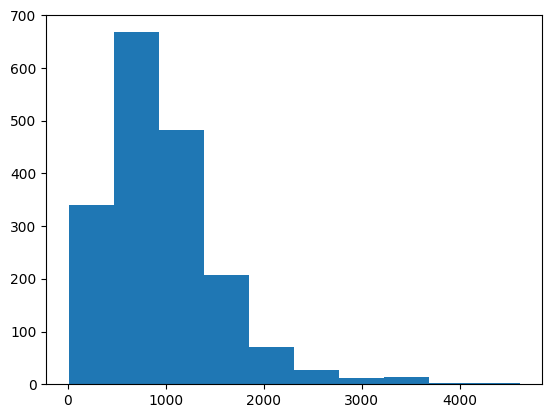

In [8]:
description_sizes = list(map(lambda d: len(d), df["description"].values))

plt.hist(description_sizes, bins=10)
plt.show()

In [9]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /home/drobec/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [12]:
en_stopwords = nltk.corpus.stopwords.words("english")

In [13]:
vectorizer = TfidfVectorizer(stop_words=en_stopwords)
corpus = df["description"].values

vectorizer.fit(corpus)

TfidfVectorizer(stop_words=['i', 'me', 'my', 'myself', 'we', 'our', 'ours',
                            'ourselves', 'you', "you're", "you've", "you'll",
                            "you'd", 'your', 'yours', 'yourself', 'yourselves',
                            'he', 'him', 'his', 'himself', 'she', "she's",
                            'her', 'hers', 'herself', 'it', "it's", 'its',
                            'itself', ...])

In [16]:
tf_idf_descriptions = vectorizer.transform(df["description"].values)
tf_idf_descriptions.shape

(1825, 7340)

In [38]:
numerical_difficulties = { "Easy": 0, "Medium": 1, "Hard": 2 }

X, y = [], []
for tokenized_description, difficulty in zip(tf_idf_descriptions, df["difficulty"].values):
    X.append(tokenized_description.todense())
    y.append(numerical_difficulties[difficulty])

In [39]:
N = len(X)
TRAIN_SIZE = int(N * 0.8)
VALIDATION_SIZE = N - TRAIN_SIZE

print(f'{TRAIN_SIZE=}, {VALIDATION_SIZE=}')

features_dataset = tf.data.Dataset.from_tensor_slices(X)
target_dataset = tf.data.Dataset.from_tensor_slices(y)
combined_dataset = tf.data.Dataset.zip((features_dataset, target_dataset))

train = combined_dataset.take(TRAIN_SIZE).shuffle(TRAIN_SIZE, seed=SEED).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
validation = combined_dataset.skip(TRAIN_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

TRAIN_SIZE=1460, VALIDATION_SIZE=365


In [25]:
input = tf.keras.layers.Input(shape=(None, tf_idf_descriptions.shape[1]))

hidden = tf.keras.layers.Dense(
    units=64,
    activation=tf.nn.relu
)(input)

output = tf.keras.layers.Dense(
    units=3,
    activation=tf.nn.softmax
)(hidden)

mlp_64relu = tf.keras.models.Model(inputs=input, outputs=output, name="mlp_64relu")

mlp_64relu.compile(
    optimizer=tf.optimizers.Adam(jit_compile=False),
    loss=tf.losses.SparseCategoricalCrossentropy(),
    metrics=[tf.metrics.F1Score(average="weighted", name="f1"), tf._metrics.SparseCategoricalAccuracy("sparseCatAcc")]
)

In [26]:
mlp_64relu.summary()

Model: "mlp_64relu"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, None, 7340)]      0         
                                                                 
 dense_6 (Dense)             (None, None, 64)          469824    
                                                                 
 dense_7 (Dense)             (None, None, 3)           195       
                                                                 
Total params: 470019 (1.79 MB)
Trainable params: 470019 (1.79 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
mlp_64relu.fit(
    train,
    epochs=20,
    callbacks=[
        tf.keras.callbacks.TensorBoard('./models/logs/mlp_relu64'),
        tf.keras.callbacks.ModelCheckpoint(
            filepath='./models/mlp_relu64_{epoch}.h5',
            monitor='val_loss',
            mode='min',
            save_best_only=True,
            verbose=1
        ),
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            mode='min',
            patience=3,
            verbose=1,
            restore_best_weights=True
        )
    ],
    validation_data=validation
)